<div align='center'><strong>Wikipedia Pageviews Project</strong>
<br />
<i>Netanel Madmoni</i>
</div>

----------------

# Introduction

In [1]:
#imports
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm
from functools import reduce
from itertools import product
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import json
import seaborn as sns
from rich import print
from IPython.display import Image

load_dotenv()

RAW_DATA_DIR = Path(os.getenv('RAW_DATA_DIR'))
PROCESSED_DATA_DIR = Path(os.getenv('PROCESSED_DATA_DIR'))

# Raw Data Acquisition

1. Get List of people on Wikipedia
```sql
SELECT DISTINCT en_wiki -- page title name in english wikipedia	
FROM  `rising-theater-416315.wikipedia_pageviews.wikidata`,
      UNNEST(instance_of) AS instance_of_struct

    
WHERE instance_of_struct.numeric_id = 5 -- instance_of = 5 => person
```

2. Get pagevoew data for those people

      ```sql
      SELECT title, DATETIME_TRUNC(datehour, MONTH) AS month, SUM(views) AS monthly_views

                  
      FROM  `rising-theater-416315.wikipedia_pageviews.pageviews_2023` a
            JOIN `rising-theater-416315.data_for_project.distinct_people` b
            ON a.title = b.en_wiki

      
      WHERE datehour IS NOT NULL
      AND wiki = "en"

      GROUP BY title, DATETIME_TRUNC(datehour, MONTH)
      ```

3. Get wikidata for those people
      ```sql
      SELECT *	
      FROM  `rising-theater-416315.wikipedia_pageviews.wikidata`,
      UNNEST(instance_of) AS instance_of_struct

    
      WHERE instance_of_struct.numeric_id = 5
      ```

# Data transformation

## Views Data

Are organized in csv files, one per year.

In [6]:
# Read raw data
dfs = []
for file in RAW_DATA_DIR.glob(r'monthly_views_*.csv'):
    print(f'{file.name} - {os.stat(file).st_size / 1024 ** 2:.2f} MB)')
    dfs.append(pl.read_csv(file))

print(f'Total files: {len(dfs)}')

monthly_views_2015.csv - 411.06 MB)
monthly_views_2016.csv - 658.91 MB)
monthly_views_2019.csv - 803.42 MB)
monthly_views_2020.csv - 851.54 MB)
monthly_views_2017.csv - 708.39 MB)
monthly_views_2022.csv - 949.62 MB)
monthly_views_2023.csv - 980.47 MB)
monthly_views_2021.csv - 904.32 MB)
monthly_views_2018.csv - 755.98 MB)
Total files: 0


In [51]:
try:
    views_df = pl.read_parquet(PROCESSED_DATA_DIR / 'pageviews_all.parquet')
except FileNotFoundError:
    # Pivot
    transformed_dfs = []
    for df in tqdm(dfs):
        transformed_df = (df.with_columns(pl.col('month')
                                        .map_elements(lambda s: f'{s[:4]}-{s[5:7]}')
                                        .alias('year_month'))
                        .pivot(index='title', columns='year_month', values='monthly_views')
        )
        transformed_dfs.append(transformed_df)
    # Join
    all_names = pl.concat([df.select('title') for df in dfs]).unique()
    print(f'{len(all_names):,}')
    views_df = all_names
    for i, df in tqdm(enumerate(transformed_dfs)):
        views_df = df.join(views_df, 'title', 'outer_coalesce')
    views_df = views_df.select(['title', *sorted([c for c in views_df.columns if c != 'title'])])
    views_df.write_parquet(f'{PROCESSED_DATA_DIR}/pageviews_all.parquet')

views_df

title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Edgar_Dibden""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,16,6,10,6,7,4,2
"""David_Mulready…",56,51,78,51,54,59,36,44,31,33,29,29,29,54,44,45,23,36,38,35,32,31,42,27,44,33,27,52,29,41,21,36,47,64,37,30,…,16,21,27,33,15,22,31,15,25,16,25,12,25,27,31,18,27,25,20,21,34,15,16,14,15,19,26,19,18,12,7,19,12,14,14,7,6
"""Bruno_Riem""",40,29,34,17,31,29,22,31,14,8,8,16,13,16,7,17,24,16,20,14,14,7,23,16,25,14,13,15,13,20,10,17,31,14,13,12,…,4,9,2,4,5,4,7,8,6,7,8,5,5,4,4,7,2,5,4,11,2,4,5,5,3,5,2,2,4,3,7,5,4,3,3,1,2


### Additional Features Extraction

## Entity Data

### Reading the Data

Are organized in json files.

In [2]:
info_files = (RAW_DATA_DIR / 'wikidata').glob('*')
len(list(info_files))

400

For example...

In [2]:
info_files = (RAW_DATA_DIR / 'wikidata').glob('*')
with open(next(info_files)) as f:
    for line in f:
        d = json.loads(line)
        sites = [sitelink['site'] for sitelink in d['sitelinks']]
        if 'enwiki' in sites:
            print(d)
            break
    

{
    'id': 'Q17122148',
    'numeric_id': '17122148',
    'en_label': 'Albrecht Joseph',
    'en_wiki': 'Albrecht_Joseph',
    'en_description': 'German screenwriter, film editor and author',
    'type': 'item',
    'sitelinks': [
        {'site': 'dewiki', 'title': 'Albrecht Joseph', 'encoded': 'Albrecht_Joseph'},
        {'site': 'enwiki', 'title': 'Albrecht Joseph', 'encoded': 'Albrecht_Joseph'},
        {'site': 'frwiki', 'title': 'Albrecht Joseph', 'encoded': 'Albrecht_Joseph'},
        {'site': 'arwiki', 'title': 'ألبرشت جوزيف', 'encoded': 'ألبرشت_جوزيف'},
        {'site': 'arzwiki', 'title': 'البرشت چوزيف', 'encoded': 'البرشت_چوزيف'},
        {'site': 'fawiki', 'title': 'آلبرشت یوزف', 'encoded': 'آلبرشت_یوزف'}
    ],
    'descriptions': [
        {'language': 'de', 'value': 'deutsch-amerikanischer Theater- und Filmschaffender'},
        {'language': 'fa', 'value': 'فیلمنامه\u200cنویس، تدوینگر، و نویسنده آلمانی'},
        {'language': 'en', 'value': 'German screenwriter, film editor and author'},
        {'language': 'nl', 'value': 'Duits scenarioschrijver (1901-1991)'},
        {'language': 'sv', 'value': 'tysk författare och filmklippare'}
    ],
    'labels': [
        {'language': 'de', 'value': 'Albrecht Joseph'},
        {'language': 'fr', 'value': 'Albrecht Joseph'},
        {'language': 'nl', 'value': 'Albrecht Joseph'},
        {'language': 'en', 'value': 'Albrecht Joseph'},
        {'language': 'es', 'value': 'Albrecht Joseph'},
        {'language': 'hu', 'value': 'Albrecht Joseph'},
        {'language': 'sl', 'value': 'Albrecht Joseph'},
        {'language': 'ca', 'value': 'Albrecht Joseph'},
        {'language': 'ast', 'value': 'Albrecht Joseph'},
        {'language': 'ar', 'value': 'ألبرشت جوزيف'},
        {'language': 'cs', 'value': 'Albrecht Joseph'},
        {'language': 'sk', 'value': 'Albrecht Joseph'},
        {'language': 'arz', 'value': 'البرشت چوزيف'},
        {'language': 'it', 'value': 'Albrecht Joseph'},
        {'language': 'sq', 'value': 'Albrecht Joseph'},
        {'language': 'he', 'value': "אלברכט ג'וזף"},
        {'language': 'sv', 'value': 'Albrecht Joseph'},
        {'language': 'ga', 'value': 'Albrecht Joseph'},
        {'language': 'fa', 'value': 'آلبرشت یوزف'},
        {'language': 'ru', 'value': 'Элбрехт Джозеф'}
    ],
    'aliases': [
        {'language': 'de', 'value': 'Al Joseph'},
        {'language': 'en', 'value': 'Al Joseph'},
        {'language': 'cs', 'value': 'Al Joseph'},
        {'language': 'sk', 'value': 'Al Joseph'}
    ],
    'instance_of': [{'numeric_id': '5'}],
    'gender': [{'numeric_id': '6581097'}],
    'date_of_birth': [{'time': '+1901-11-20T00:00:00Z'}],
    'date_of_death': [{'time': '+1901-11-20T00:00:00Z'}],
    'worked_at': [],
    'country_of_citizenship': [{'numeric_id': '183'}],
    'country': [],
    'educated_at': [],
    'occupation': [{'numeric_id': '28389'}, {'numeric_id': '7042855'}, {'numeric_id': '36180'}],
    'instrument': [],
    'genre': [],
    'industry': [],
    'subclass_of': [],
    'coordinate_location': [],
    'iso_3166_alpha3': [],
    'member_of': [],
    'from_fictional_universe': []
}

In [3]:
try:
    info_df = pl.read_parquet(PROCESSED_DATA_DIR / 'wikidata_all.parquet')
except FileNotFoundError:
    info_list = []
    info_files = (RAW_DATA_DIR / 'wikidata').glob('*')
    for file in info_files:
        with open(file) as f:
            for line in f:
                d = json.loads(line)
                sites = [sitelink['site'] for sitelink in d['sitelinks']]
                if 'enwiki' in sites:
                    info_list.append(d)
    info_df = pl.DataFrame(info_list)

with pl.Config(tbl_rows=3):
    display(info_df)

id,numeric_id,en_label,en_wiki,en_description,type,sitelinks,descriptions,labels,aliases,instance_of,gender,date_of_birth,date_of_death,worked_at,country_of_citizenship,country,educated_at,occupation,instrument,genre,industry,subclass_of,coordinate_location,iso_3166_alpha3,member_of,from_fictional_universe
str,str,str,str,str,str,list[struct[3]],list[struct[2]],list[struct[2]],list[struct[2]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[2]],list[null],list[struct[1]],list[struct[1]]
"""Q17122148""","""17122148""","""Albrecht Josep…","""Albrecht_Josep…","""German screenw…","""item""","[{""dewiki"",""Albrecht Joseph"",""Albrecht_Joseph""}, {""enwiki"",""Albrecht Joseph"",""Albrecht_Joseph""}, … {""fawiki"",""آلبرشت یوزف"",""آلبرشت_یوزف""}]","[{""de"",""deutsch-amerikanischer Theater- und Filmschaffender""}, {""fa"",""فیلمنامه‌نویس، تدوینگر، و نویسنده آلمانی""}, … {""sv"",""tysk författare och filmklippare""}]","[{""de"",""Albrecht Joseph""}, {""fr"",""Albrecht Joseph""}, … {""ru"",""Элбрехт Джозеф""}]","[{""de"",""Al Joseph""}, {""en"",""Al Joseph""}, … {""sk"",""Al Joseph""}]","[{""5""}]","[{""6581097""}]","[{""+1901-11-20T00:00:00Z""}]","[{""+1901-11-20T00:00:00Z""}]",[],"[{""183""}]",[],[],"[{""28389""}, {""7042855""}, {""36180""}]",[],[],[],[],[],[],[],[]
"""Q100707809""","""100707809""","""Robert Cahaly""","""Robert_Cahaly""","""American polls…","""item""","[{""enwiki"",""Robert Cahaly"",""Robert_Cahaly""}, {""jawiki"",""ロバート・カヘリー"",""ロバート・カヘリー""}]","[{""en"",""American pollster and political consultant""}, {""zh"",""美国民调专家""}]","[{""en"",""Robert Cahaly""}, {""de"",""Robert Cahaly""}, … {""pt-br"",""Robert Cahaly""}]",[],"[{""5""}]","[{""6581097""}]",[],[],"[{""100704905""}]","[{""30""}]",[],"[{""1024426""}]","[{""16919156""}, {""8125919""}]",[],[],[],[],[],[],[],[]
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q6128908""","""6128908""","""James Ashurst""","""James_Ashurst""","""English minist…","""item""","[{""enwiki"",""James Ashurst"",""James_Ashurst""}]","[{""en"",""English minister""}, {""nl"",""ambtenaar""}]","[{""en"",""James Ashurst""}, {""es"",""James Ashurst""}, … {""sq"",""James Ashurst""}]",[],"[{""5""}]","[{""6581097""}]","[{""+1605-01-01T00:00:00Z""}]","[{""+1605-01-01T00:00:00Z""}]",[],[],[],[],"[{""212238""}]",[],[],[],[],[],[],[],[]


Lets' look at the columns:

In [92]:
info_df.columns

['id',
 'numeric_id',
 'en_label',
 'en_wiki',
 'en_description',
 'type',
 'sitelinks',
 'descriptions',
 'labels',
 'aliases',
 'instance_of',
 'gender',
 'date_of_birth',
 'date_of_death',
 'worked_at',
 'country_of_citizenship',
 'country',
 'educated_at',
 'occupation',
 'instrument',
 'genre',
 'industry',
 'subclass_of',
 'coordinate_location',
 'iso_3166_alpha3',
 'member_of',
 'from_fictional_universe']

**Columns description** from the Wikidata Database (I've used the [Wikidata Property Explorer](https://prop-explorer.toolforge.org/)):
- `id`, `numeric_id` - entity identifiers.
- `en_wiki`, `en_label`, `en_description` - English wiki-name, label (human-readable name) and description of the entity.
- `type` - type of entity (item/property/etc. See https://www.wikidata.org/wiki/Wikidata:Identifiers).
- `sitelinks` - a list of *struct*s (dictionary-like data structure) containing site name, wiki-name, and label of the entity in all the wikis it is in.
- `descriptions`, `labels`, `aliases` - lists of structs containing site name, description of the entity in that site, label and aliases of entity in that site.
- `instance_of` - "that class[es] of which this subject is a particular example and member". In this dataset I've taken only entities that are an instance of `Human (Q5)`.
- `gender` - "sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender, etc."
- `date_of_birth`/`death` - "date on which the subject was born / died"
- `worked_at` - "location where persons or organisations were actively participating in employment, business or other work"
- `country_of_citizenship` - "the object is a country that recognizes the subject as its citizen"
- `country` - "sovereign state that this item is in ***(not to be used for human beings)***"
- `educated_at` - "educational institution attended by subject"
- `occupation` - "occupation of a person"
- `instrument` - "musical instrument that a person plays or teaches or used in a music occupation"
- `genre` - "creative work's genre or an artist's field of work"
- `industry` - "specific industry of company or organization"
- `subclass_of` - "this item is a subclass (subset) of that item; all instances of this item are instances of that item. different from P31 (instance of), e.g.: K2 is an instance of mountain; volcano is a subclass of mountain (and an instance of volcanic landform)"
- `coordinate_location` - "geocoordinates of the subject"
- `iso_3166_alpha3` - "identifier for a country in three-letter format"
- `member_of` - "organization, club or musical group to which the subject belongs"
- `from_fictional_universe` - "subject's fictional entity is in the object narrative".

### Cleaning the Data

Let's look at the columns and their data types.

In [3]:
print(dict(zip(info_df.columns, info_df.dtypes)))

{
    'id': String,
    'numeric_id': String,
    'en_label': String,
    'en_wiki': String,
    'en_description': String,
    'type': String,
    'sitelinks': List(Struct({'site': String, 'title': String, 'encoded': String})),
    'descriptions': List(Struct({'language': String, 'value': String})),
    'labels': List(Struct({'language': String, 'value': String})),
    'aliases': List(Struct({'language': String, 'value': String})),
    'instance_of': List(Struct({'numeric_id': String})),
    'gender': List(Struct({'numeric_id': String})),
    'date_of_birth': List(Struct({'time': String})),
    'date_of_death': List(Struct({'time': String})),
    'worked_at': List(Struct({'numeric_id': String})),
    'country_of_citizenship': List(Struct({'numeric_id': String})),
    'country': List(Struct({'numeric_id': String})),
    'educated_at': List(Struct({'numeric_id': String})),
    'occupation': List(Struct({'numeric_id': String})),
    'instrument': List(Struct({'numeric_id': String})),
    'genre': List(Struct({'numeric_id': String})),
    'industry': List(Struct({'numeric_id': String})),
    'subclass_of': List(Struct({'numeric_id': String})),
    'coordinate_location': List(Struct({'latitude': Float64, 'longitude': Float64})),
    'iso_3166_alpha3': List(Null),
    'member_of': List(Struct({'numeric_id': String})),
    'from_fictional_universe': List(Struct({'numeric_id': String}))
}

One of the challenges in this dataset is the abundance of `List` and `Struct` (a dictionary-like) data types. Meaning, each cell can have multiple values in it. This section will mostly focus on how to solve this problem.

✨ I shall treat the `List` columns differently than the "normal" columns when transforming and exploring the data.

**Questions for cleaning the data:**
1. Are there any duplicate rows?
2. Are there any columns that contain nothing but empty lists or null values? Are there columns that are *mostly* empty?
3. Are there any list/struct columns that always contain a single value (= lists that can be flattened)?
4. How many unique values does each column contains?

**Preliminary notes:**
* The values in `date_of_death` column are wrong (for some reason). I shall drop that column.
* According to [the Wikidata site](https://www.wikidata.org/wiki/Property:P17), this property should not be used for humans. I shall drop this columns as well.


---

* **Duplicate rows**

In [21]:
duplicated_df = info_df.filter(info_df['id'].is_duplicated())

print(f'There are {duplicated_df.height} rows carrying duplicate `id`s.')

There are 22 rows carrying duplicate `id`s.

✨ I will delete all the duplicate rows.

* **Empty columns**

In [56]:
columns_to_bin = [c for c in info_df.columns if info_df[c].dtype == pl.List]

empty = []

for column in [c for c in info_df.columns if c not in columns_to_bin]:
    empty.append([column,
                         (info_df[column]
                         .is_null()
                         .value_counts()
                         .filter(pl.col(column))
                         .select('count')
                         .to_numpy()).squeeze()])

for column in columns_to_bin:
    empty.append([column,
                         ((info_df[column]
                         .list.len() == 0)
                         .value_counts()
                         .filter(pl.col(column))
                         .select('count')
                         .to_numpy()).squeeze()])

for item in empty:
    if not item[1].any():
        item[1] = 0
    item.append(item[1] / info_df.height * 100)

empty_df = (pd.DataFrame(empty, columns=['column', 'num_empty', 'percent_empty'])
            .sort_values('percent_empty', ascending=False)
            )
empty_df.style.format({'percent_empty': '{:.3f}%', 'num_empty': '{:,}'})

,column,num_empty,percent_empty
24,iso_3166_alpha3,"1,993,448",100.000%
26,from_fictional_universe,"1,993,443",100.000%
22,subclass_of,"1,993,431",99.999%
23,coordinate_location,"1,993,423",99.999%
21,industry,"1,993,082",99.982%
16,country,"1,992,209",99.938%
20,genre,"1,918,158",96.223%
19,instrument,"1,904,077",95.517%
25,member_of,"1,882,243",94.421%
14,worked_at,"1,811,036",90.849%


✨ Column `iso_3166_alpha3` is completely empty. I shall drop it.

✨ There are a few columns that are >90% empty. I will leave them there for now, as they might prove useful later on.




* **How many values in each list column?**

In [72]:
with pl.Config(tbl_rows=-1):
  display(info_df[columns_to_bin]
          .with_columns([pl.col(c).list.n_unique() for c in columns_to_bin])
          .describe()
          .filter(pl.col('statistic').is_in(['mean', 'std', 'min', '50%', 'max']))
          .transpose(include_header=True, column_names='statistic')
          .sort('max')
  )

column,mean,std,min,50%,max
str,f64,f64,f64,f64,f64
"""iso_3166_alpha…",0.0,0.0,0.0,0.0,0.0
"""from_fictional…",0.000003,0.001584,0.0,0.0,1.0
"""subclass_of""",0.000009,0.003167,0.0,0.0,2.0
"""coordinate_loc…",0.000013,0.003748,0.0,0.0,2.0
"""country""",0.000624,0.025093,0.0,0.0,3.0
"""gender""",1.00013,0.021377,0.0,1.0,4.0
"""industry""",0.000319,0.026319,0.0,0.0,4.0
"""date_of_birth""",0.942715,0.377177,0.0,1.0,8.0
"""date_of_death""",0.942715,0.377177,0.0,1.0,8.0


✨ The only list column that contains only one value is `from_fictional_universe`. I shall flatten it.

Other columns make sense to have more than one unique value per row, except for date of birth column. Are they simply duplicates?

In [89]:
dob_year_month = info_df['date_of_birth'].filter(info_df['date_of_birth'].list.len() > 1).list.eval(pl.element().struct[0].str.slice(1, 6))

print(f'Out of {dob_year_month.len():,} rows that have more than one date of birth,'
      f'{(dob_year_month.list.n_unique() == 1).sum() / dob_year_month.len() * 100:.2f}% '
      'have the same date of birth duplicated.')

Out of 79,284 rows that have more than one date of birth,57.40% have the same date of birth duplicated.

✨ For our purposes, I'll simply take the first date of birth that appears in each row. 

* **Unique values**

In [53]:
unique_value_counts = []
for column in columns_to_bin:
    unique_value_counts.append((column, info_df[column].list.explode().n_unique()))
for column in [c for c in info_df.columns if c not in columns_to_bin]:
    unique_value_counts.append((column, info_df[column].n_unique()))
    
unique_df = (pd.DataFrame(unique_value_counts, columns=['column', 'unique_values'])
            .sort_values('unique_values')
            )
unique_df.style.format('{:,}', subset='unique_values')

,column,unique_values
26,type,1
18,iso_3166_alpha3,1
20,from_fictional_universe,6
16,subclass_of,19
17,coordinate_location,26
5,gender,45
15,industry,71
10,country,118
4,instance_of,357
13,instrument,767


✨ The column `type` contains only one value for all rows. I shall remove it.

Interesting points:
* apparently there are 45(!) different genders.
* Many columns have a lot of unique values.

✨ For columns with many unique values, I shall bin the less common one (replace them with *`other`*).

A summary table up until now:

In [57]:
pd.merge(unique_df, empty_df, on='column').style.format({'percent_empty': '{:.3f}%',
                                                         'num_empty': '{:,}',
                                                         'unique_values': '{:,}'})

,column,unique_values,num_empty,percent_empty
0,type,1,0,0.000%
1,iso_3166_alpha3,1,"1,993,448",100.000%
2,from_fictional_universe,6,"1,993,443",100.000%
3,subclass_of,19,"1,993,431",99.999%
4,coordinate_location,26,"1,993,423",99.999%
5,gender,45,302,0.015%
6,industry,71,"1,993,082",99.982%
7,country,118,"1,992,209",99.938%
8,instance_of,357,0,0.000%
9,instrument,767,"1,904,077",95.517%


---

✨ **Observations:**

There are a few types of columns:
1. Redundant columns: columns that don't add information, either because they contain the same value throughout, have many missing values or do not contribute to our specific needs. The columns are:
    - `type` (same value for all rows)
    - `numeric_id` (contained in `id`)
    - `descriptions` (unneeded information)
    - `labels` (unneeded information)
    - `coordinate_location`(>99% empty)
    - `country` (according to the Wikidata site, this property should not be used for humans)
    - `date_of_death` (has wrong information)
    - `iso_3166_alpha3` (empty)

2. Columns with a single value per row: columns that (should) have zero or one values for each row. These columns are:
    - `id`
    - `en_label`
    - `en_wiki`
    - `en_description`
    - `date of birth` (take only the first one for each row)

3. Columns with *'interesting'* values per row: columns that contain zero, one or more values for each row, where every (major) value is *interesting* for our purpose. These columns are:
    - `instance_of`
    - `gender` (apparently an entity can have multiple genders)
    - `sitelinks`
    - `instrument`
    - `worked_at`
    - `country_of_citizenship`
    - `educated_at`
    - `occupation`
    - `genre`
    - `industry`
    - `subclass_of`
    - `member_of`
    - `from_fictional_universe`

4. Columns that have multiple values per row: columns that have multiple values per row, where an aggregation of these values is *interesting* for our purposes. These columns are:
    - `gender`
    - `sitelinks`
    - `aliases` (We don't care what the aliases *are*, maybe just how many are there)
    - `instrument`
    - `worked_at`
    - `country_of_citizenship`
    - `educated_at`
    - `occupation`
    - `genre`
    - `industry`

 **Note** that a column might be a member of both the third group as well as the fourth group.

Handling strategy for each type of column:
1. Redundant columns --> drop columns.
2. Columns with a single value per row: --> leave as is (flatten if in a list or a struct).
3. Columns with *'interesting'* values per row --> encode into binary columns (bin uncommon values, or combine with more common ones) and drop original.
4. Columns that have multiple values per row --> create a column with the aggregate metric and drop original.

Types 1 and 2 are easy as the process is automatic. For types 3 and 4, we would have to look at the distribution of values in each of the columns. Before we can do that, it would have been helpful to convert the codes in the dataset into human-readable labels. However, due to the large number of unique codes it is unrealistic to fetch all of the labels right now. I will do that once we have a smaller number of them.

#### Examining Distributions of Value Counts

In [7]:
columns_to_bin = ['instance_of', 'gender', 'worked_at', 'sitelinks',
                      'country_of_citizenship', 'educated_at', 'occupation',
                      'instrument', 'genre', 'industry', 'subclass_of', 'member_of',
                      'from_fictional_universe']
value_counts = {col: info_df[col].list.eval(pl.element().struct[0])
                .explode().value_counts().sort('count', descending=True)
                for col in columns_to_bin}

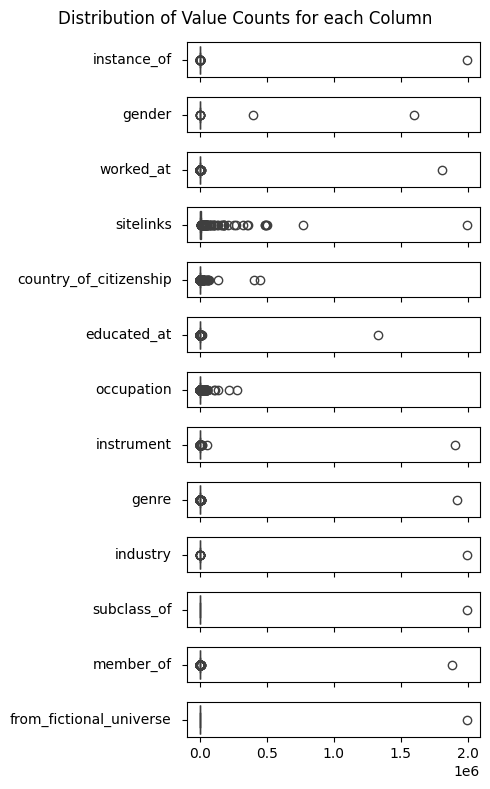

In [54]:
fig, axs = plt.subplots(13, figsize=(5, 8), sharex=True)
for (name, df), ax in zip(value_counts.items(), axs.ravel()):
    sns.boxplot(x=df['count'], ax=ax)
    ax.set_ylabel(name, rotation='horizontal', ha='right', va='center')
    ax.set_xlabel('')
fig.suptitle('Distribution of Value Counts for each Column')
plt.tight_layout()
plt.show()

As suspected, almost all columns consist of one or two 'big' groups and many 'small' groups.

✨ For each column I will keep the three most common groups and combine the others.


---

With all that, let us clean the dataframe:

In [74]:
def clean_info_df(df: pl.DataFrame):
      
      ## Drop columns, remove duplicate rows, unnest structs ########
      columns_to_drop = ['type', 'numeric_id', 'descriptions', 'labels',
                         'iso_3166_alpha3', 'coordinate_location', 'country',
                         'iso_3166_alpha3', 'date_of_death']
      struct_columns = [c for c in df.columns if df[c].dtype == pl.List and c not in columns_to_drop]

      df = (df
            .unique('id') # Remove duplicate rows
            .drop(columns_to_drop) # drop redundant columns
            .with_columns([pl.col(col).list.eval(pl.element().struct[0]) for col in struct_columns]) # unnest structs
            .with_columns(pl.col('date_of_birth').list[0]) # Only the first date of birth
      )
      
      
      ## Bin list columns ###########################
      columns_to_bin = ['instance_of', 'gender', 'worked_at', 'sitelinks',
                      'country_of_citizenship', 'educated_at', 'occupation',
                      'instrument', 'genre', 'industry', 'subclass_of', 'member_of',
                      'from_fictional_universe']
      
      value_counts = {col: df[col].explode().value_counts()
                      .sort('count', descending=True) for col in columns_to_bin}
      

      for col, counts_df in value_counts.items():
            percent_to_keep = 0.1
            values_to_keep = counts_df.filter(pl.col('count') > percent_to_keep * df.height).height
            binned = (df[['en_wiki', col]]
                      .explode(col)
                      .with_columns(pl.when(pl.col(col).is_in(counts_df[col][:values_to_keep]).or_(pl.col(col).is_null()))
                                    .then(pl.col(col))
                                    .otherwise(pl.lit('other')))
                      .unique()
                      .group_by('en_wiki')
                      .agg(col))
            df = df.join(binned, 'en_wiki', 'left', suffix='_binned')
      
      # Create columns based on aggregates (counts) ###############
      columns_to_aggregate = ['gender', 'sitelinks', 'aliases', 'instrument',
                              'worked_at', 'country_of_citizenship', 'educated_at',
                              'occupation', 'genre', 'industry']
      df = df.with_columns([pl.col(col).list.len().alias(f'count_{col}') for col in columns_to_aggregate])
     
      return df


In [75]:
info_df_cleaned = clean_info_df(info_df)
info_df_cleaned

id,en_label,en_wiki,en_description,sitelinks,aliases,instance_of,gender,date_of_birth,worked_at,country_of_citizenship,educated_at,occupation,instrument,genre,industry,subclass_of,member_of,from_fictional_universe,instance_of_binned,gender_binned,worked_at_binned,sitelinks_binned,country_of_citizenship_binned,educated_at_binned,occupation_binned,instrument_binned,genre_binned,industry_binned,subclass_of_binned,member_of_binned,from_fictional_universe_binned,count_gender,count_sitelinks,count_aliases,count_instrument,count_worked_at,count_country_of_citizenship,count_educated_at,count_occupation,count_genre,count_industry
str,str,str,str,list[str],list[str],list[str],list[str],str,list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""Q7459502""","""Seán Curran""","""Seán_Curran_(h…","""Irish hurler""","[""enwiki"", ""gawiki"", ""arwiki""]","[""nl"", ""en""]","[""5""]","[""6581097""]","""+1981-11-11T00…",[],"[""27""]",[],"[""18199024""]",[],[],[],[],[],[],"[""5""]","[""6581097""]",[null],"[""arwiki"", ""other"", ""enwiki""]","[""other""]",[null],"[""other""]",[null],[null],[null],[null],[null],[null],1,3,2,0,0,1,0,1,0,0
"""Q15993641""","""Richard Weinga…","""Richard_Weinga…","""American engin…","[""enwiki""]","[""en""]","[""5""]","[""6581097""]","""+1938-03-23T00…","[""49213"", ""1468161""]","[""30""]","[""1206658"", ""1468161""]","[""13582652"", ""36180"", … ""43845""]",[],[],[],[],[],[],"[""5""]","[""6581097""]","[""other""]","[""enwiki""]","[""30""]","[""other""]","[""other""]",[null],[null],[null],[null],[null],[null],1,1,1,0,2,1,2,4,0,0
"""Q23771467""","""Colin Tizzard""","""Colin_Tizzard""","""British raceho…","[""enwiki""]",[],"[""5""]","[""6581097""]","""+1956-01-07T00…",[],[],[],"[""466640""]",[],[],[],[],[],[],"[""5""]","[""6581097""]",[null],"[""enwiki""]",[null],[null],"[""other""]",[null],[null],[null],[null],[null],[null],1,1,0,0,0,0,0,1,0,0
"""Q712139""","""Porter Wagoner…","""Porter_Wagoner…","""American recor…","[""commonswiki"", ""enwiki"", … ""arzwiki""]","[""sv"", ""ru"", … ""hy""]","[""5""]","[""6581097""]","""+1927-08-12T00…",[],"[""30""]",[],"[""177220"", ""33999"", … ""55960555""]","[""6607"", ""17172850""]","[""83440""]",[],[],[],[],"[""5""]","[""6581097""]",[null],"[""enwiki"", ""ruwiki"", … ""arwiki""]","[""30""]",[null],"[""other""]","[""other""]","[""other""]",[null],[null],[null],[null],1,19,6,2,0,1,0,5,1,0
"""Q16003727""","""Roy Moir""","""Roy_Moir""","""politician in …","[""enwiki"", ""arzwiki"", ""arwiki""]","[""en"", ""en""]","[""5""]","[""6581097""]","""+1897-12-23T00…",[],"[""408""]",[],"[""82955""]",[],[],[],[],[],[],"[""5""]","[""6581097""]",[null],"[""arzwiki"", ""arwiki"", ""enwiki""]","[""other""]",[null],"[""82955""]",[null],[null],[null],[null],[null],[null],1,3,2,0,0,1,0,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q5873501""","""Gabriel Pita d…","""Gabriel_Pita_d…","""Admiral (1909-…","[""eswiki"", ""cawiki"", … ""enwiki""]","[""de"", ""en"", ""es""]","[""5""]","[""6581097""]","""+1909-01-31T00…",[],"[""29""]",[],"[""10669499"", ""82955""]",[],[],[],[],[],[],"[""5""]","[""6581097""]",[null],"[""other"", ""eswiki"", ""enwiki""]","[""other""]",[null],"[""other"", ""82955""]",[null],[null],[null],[null],[null],[null],1,4,3,0,0,1,0,2,0,0
"""Q26704505""","""Angela Dwamena…","""Angela_Dwamena…","""Ghanaian lawye…","[""enwiki"", ""frwiki"", ""arzwiki""]",[],"[""5""]","[""6581072""]","""+1965-00-00T00…",[],"[""117""]","[""19605635"", ""16915546"", … ""16733633""]","[""40348"", ""121998"", ""1569495""]",[],[],[],[],[],[],"[""5""]","[""6581072""]",[null],"[""enwiki"", ""frwiki"", ""arzwiki""]","[""other""]","[""other""]","[""other""]",[null],[null],[null],[null],[null],[null],1,3,0,0,0,1,5,3,0,0
"""Q19561353""","""Avner Mandelma…","

In [93]:
info_df_cleaned[['en_wiki', 'sitelinks']].to_dummies('sitelinks')
# see https://stackoverflow.com/questions/74432537/cast-a-list-column-into-dummy-columns-in-python-polars

ComputeError: grouping on list type is only allowed if the inner type is numeric

#### Converting Codes Into Labels

Many columns have 'numeric id's in them. These are numeric code to wikidata's property. To understand the data, we need to convert them to human-readable labels. I weill grab them straight from the wikidata website (the API has a small request limit, so I won't be using it).

First I'll get all the codes needed to be converted.

In [101]:
columns_with_codes = ['instance_of', 'gender', 'worked_at', 'sitelinks',
                      'country_of_citizenship', 'educated_at', 'occupation',
                      'instrument', 'genre', 'industry', 'subclass_of', 'member_of',
                      'from_fictional_universe']
unique_codes = [info_df[col].list.eval(pl.element().struct[0]).explode().unique().drop_nulls() for col in columns_with_codes]

In [102]:
sum([len(df) for df in unique_codes])

125026

In [41]:
import requests
from bs4 import BeautifulSoup
import time

In [42]:
def code_to_label(code):
    request = requests.get(f'https://www.wikidata.org/wiki/Q{code}')
    if request.status_code != 200:
        raise
    page = request.content
    soup = BeautifulSoup(page)
    label = soup.find('span', {'class': 'wikibase-title-label'}).text
    return label

In [32]:
code_to_label('47064')

'military personnel'

In [54]:
singers = info_df.filter(pl.col('instrument').list.eval(pl.element().struct[0]).list.contains('17172850')).select('en_wiki')
singers_views = singers.join(views_df, left_on='en_wiki', right_on='title')
singers_views

en_wiki,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Mary_Ann_Wrigh…",58,39,41,61,50,63,63,48,49,48,60,89,59,34,33,57,32,51,50,58,37,59,59,31,37,16,23,22,35,22,23,42,65,28,42,49,…,18,18,12,24,30,33,16,20,16,25,17,24,15,19,22,16,26,13,17,31,14,16,25,16,20,28,21,24,30,19,20,11,19,23,24,43,39
"""Malena_Gracia""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,715,1038,575,263,478,229,225,218,303,145,130,106,139,181,123,161,148,462,1013,194,142,337,188,175,204,142,109,110,279,163,183,270,291,128,116,881,231
"""Ramdas_Kamat""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,191,91,56,65,35,76,52,89,72,53,55,54,51,63,57,62,55,60,64,54,60,56,…,34,34,77,46,44,47,39,30,15,34,39,25,28,1137,123,57,50,42,42,53,54,42,38,29,36,46,26,30,26,27,30,27,27,43,33,34,37
"""Zheng_Cao""",2553,1344,2173,1673,1578,2355,1289,1450,1492,1481,1555,1280,1429,1585,2048,1860,2393,2372,1115,2067,2807,1201,2585,1511,1431,2320,1826,1561,1355,1498,1252,957,1273,973,986,980,…,1045,955,1084,832,917,1674,1318,1266,725,733,1213,972,517,819,1001,700,982,1434,1091,930,783,571,623,567,862,2220,1428,1173,1355,802,918,832,714,1265,612,585,522
"""Bobby_King""",680,393,392,420,502,478,414,421,391,400,415,403,354,303,313,332,371,434,400,284,449,405,464,388,317,275,262,256,306,400,354,671,683,468,426,383,…,213,234,283,259,226,269,199,199,189,222,199,223,159,256,331,231,234,256,170,246,247,254,251,223,176,226,209,229,222,168,177,310,242,221,260,195,186
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Joeystarr""",1216,1205,1008,1220,939,1304,1208,1461,1356,1629,1411,2437,1054,745,731,639,740,833,1421,1201,1409,1082,1427,1028,1186,862,1065,1028,794,807,1045,1395,1253,1276,1913,1505,…,1014,2518,3289,2278,1739,1229,993,984,1054,823,889,870,807,876,702,869,695,816,655,638,588,445,975,893,900,779,594,632,534,503,495,490,561,543,530,500,602
"""Phil_Carmen""",342,296,318,324,379,364,327,312,369,318,295,275,254,186,210,266,229,267,226,260,257,235,228,249,218,218,253,236,256,194,244,217,254,259,286,266,…,193,194,220,213,222,178,151,138,159,162,172,206,194,186,162,166,157,167,140,139,134,178,148,125,139,160,197,152,167,126,114,120,142,144,159,147,149
"""Thomas_Moore""",8777,6442,5673,5487,6896,7235,6666,6550,7005,7290,6775,6205,6259,5105,4178,4174,5070,5545,5469,4838,5596,6271,6550,6158,5714,4611,4022,3922,4733,5074,5072,4295,5298,5305,6366,4944,…,4203,4640,5836,5494,4513,4230,3618,3066,3531,3674,3758,3971,3231,3747,3797,4421,3643,3816,3082,2817,3369,3634,3913,4134,3310,3555,3344,3697,3070,3137,2727,2529,2758,3028,3731,3580,3141


In [127]:
(PROCESSED_DATA_DIR / 'codes_labels').mkdir(exist_ok=True)

for s in unique_codes:
    code2labels = {}
    for code in tqdm(s):
        code2labels[code] = code_to_label(code)
    with open(PROCESSED_DATA_DIR / 'codes_labels' / f'{s.name}.json', 'w') as f:
        json.dump(code2labels, f)

# TODO: do the opposite, request only common codes
# TODO: utf-8?

  1%|          | 240/37768 [03:43<9:42:01,  1.07it/s] 


KeyboardInterrupt: 

In [96]:
info_df.write_parquet(PROCESSED_DATA_DIR / 'wikidata_all.parquet')

Aliases not included in the pageviews data

In [60]:
(info_df['numeric_id'] == info_df['id'].str.replace('Q', '')).all()

True

Convert code to label description:
- https://stackoverflow.com/questions/59737076/how-to-get-a-label-of-a-property-from-wikidata
- https://stackoverflow.com/questions/72704205/how-to-convert-wiki-data-qid-to-entity-and-vice-versa-in-python

   1. What is the distribution of each column
1. Column-specific questions:
    1. Can an entity have more than one `gender`? Can an entity have no `gender`? If so - why?
    2. Can an entity have no `date_of_birth`? why?


### Additional Features Extraction

In [ ]:
info_df.filter(info_df['en_description'].str.starts_with('fictional'))

id,numeric_id,en_label,en_wiki,en_description,type,sitelinks,descriptions,labels,aliases,instance_of,gender,date_of_birth,date_of_death,worked_at,country_of_citizenship,country,educated_at,occupation,instrument,genre,industry,subclass_of,coordinate_location,iso_3166_alpha3,member_of,from_fictional_universe
str,str,str,str,str,str,list[struct[3]],list[struct[2]],list[struct[2]],list[struct[2]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[1]],list[struct[2]],list[null],list[struct[1]],list[struct[1]]
"""Q16209139""","""16209139""","""Norman Gunston…","""Norman_Gunston…","""fictional char…","""item""","[{""enwiki"",""Norman Gunston"",""Norman_Gunston""}]","[{""nl"",""zanger""}, {""en"",""fictional character""}, {""uk"",""вигаданий персонаж""}]","[{""en"",""Norman Gunston""}, {""de"",""Norman Gunston""}, … {""sq"",""Norman Gunston""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],"[{""177220""}]","[{""17172850""}]",[],[],[],[],[],[],[]
"""Q121026451""","""121026451""","""Mae Paner""","""Mae_Paner""","""fictional char…","""item""","[{""enwiki"",""Mae Paner"",""Mae_Paner""}]","[{""en"",""fictional character""}, {""uk"",""вигаданий персонаж""}]","[{""en"",""Mae Paner""}, {""de"",""Mae Paner""}, … {""pt-br"",""Mae Paner""}]",[],"[{""5""}]","[{""6581072""}]",[],[],[],[],[],[],"[{""2259451""}, {""1476215""}]",[],[],[],[],[],[],[],[]
"""Q5460334""","""5460334""","""Flora Malherbe…","""Flora_Malherbe…","""fictional char…","""item""","[{""enwiki"",""Flora Malherbe"",""Flora_Malherbe""}]","[{""nl"",""monteur""}, {""en"",""fictional character on the American TV sitcom The Andy Griffith Show and its successor, Mayberry RFD""}]","[{""en"",""Flora Malherbe""}, {""es"",""Flora Malherbe""}, {""ast"",""Flora Malherbe""}]",[],"[{""5""}]","[{""6581072""}]",[],[],[],[],[],[],"[{""327029""}]",[],[],[],[],[],[],[],[]
"""Q4751616""","""4751616""","""Anaranya""","""Anaranya""","""fictional char…","""item""","[{""enwiki"",""Anaranya"",""Anaranya""}, {""ptwiki"",""Anaranya"",""Anaranya""}, … {""ruwiki"",""Анаранья"",""Анаранья""}]","[{""bn"",""হিন্দু পৌরাণিক চরিত্র""}, {""en"",""fictional character""}, {""uk"",""вигаданий персонаж""}]","[{""en"",""Anaranya""}, {""pt"",""Anaranya""}, … {""ru"",""Анаранья""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
"""Q7844223""","""7844223""","""Tristram the Y…","""Tristan_the_Yo…","""fictional char…","""item""","[{""enwiki"",""Tristan the Younger"",""Tristan_the_Younger""}]","[{""en"",""fictional character in Arthurian romances""}]","[{""en"",""Tristram the Younger""}, {""ast"",""Tristram the Younger""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q7174933""","""7174933""","""Peter Jairus F…","""Peter_Jairus_F…","""fictionalized …","""item""","[{""enwiki"",""Peter Jairus Frigate"",""Peter_Jairus_Frigate""}]","[{""en"",""fictionalized version of the science fiction author Philip José Farmer in Riverworld series""}]","[{""en"",""Peter Jairus Frigate""}, {""de"",""Peter Jairus Frigate""}, … {""ast"",""Peter Jairus Frigate""}]",[],"[{""5""}]","[{""6581097""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
"""Q26409637""","""26409637""","""Amy Teo""","""Amy_Teo""","""fictional char…","""item""","[{""enwiki"",""Amy Teo"",""Amy_Teo""}]","[{""en"",""fictional character from the BBC medical drama Holby City""}]","[{""en"",""Amy Teo""}, {""nl"",""Amy Teo""}, … {""ast"",""Amy Teo""}]",[],"[{""5""}]","[{""6581072""}]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
"""Q10788162""","""10788162""","""Lý Ông Trọng""","""Ruan_Wengzhong…","""fictional char…","""item""","[{""viwiki"",""Lý Ông Trọng"",""Lý_Ông_Trọng""}, {""zhwiki"",""阮翁仲"",""阮翁仲""}, … {""thwiki"",""รฺเหวี่ยน เวิงจ้ง"",""รฺเหวี่ยน_เวิงจ้ง""}]","[{""en"",""fictional character""}, {""vi"",""

# Time Series Clustering

In [ ]:
views_df = pl.read_parquet(PROCESSED_DATA_DIR / 'pageviews_all.parquet')

In [98]:
views_df[:30]

title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
"""Carolyn_Stanfo…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,221,294,359,286,650,202,170,169,83,97,107,112,70,78,88,64,54,78,84,74,131,74,86,180,105,75,76,73,105,56,50,89,86,59,58,50,42
"""Boncho_Novakov…",16,18,26,19,21,16,11,14,18,6,6,15,4,10,10,15,14,12,11,18,14,4,22,13,15,16,8,13,11,8,7,14,18,9,7,11,…,4,7,5,3,18,39,5,3,5,5,2,4,5,3,5,5,4,6,7,3,4,5,5,5,3,9,2,3,4,4,3,7,9,2,3,2,3
"""Margaret_Hodge…",5665,2932,2420,2482,3097,2693,1955,1867,3365,2059,1808,3435,4174,12893,4331,4311,3434,2573,2110,1829,1813,1953,1667,2523,2442,3777,1705,1577,5159,1650,3699,1623,2057,1368,2277,2749,…,2260,1819,2069,1605,1630,1890,2082,1391,1126,1351,2217,1430,4400,1788,2612,1680,1471,1743,1336,2097,1272,1918,2196,1194,1204,1536,2234,1909,1311,1261,3170,2097,1026,1335,5767,2327,3310
"""Carmen_Belén_R…",null,null,null,null,null,25,26,31,27,60,35,32,29,20,20,51,23,31,37,31,59,46,51,35,28,31,34,34,25,42,27,39,118,56,36,46,…,17,24,56,80,25,32,31,13,24,25,18,27,27,18,46,54,20,24,30,12,14,12,25,27,10,31,36,63,29,12,10,15,36,20,15,20,17


In [118]:
X_train = views_df.select([col for col in views_df.columns if col != 'title']).fill_null(0).to_numpy()
X_train

array([[ 0,  0,  0, ..., 44, 23, 25],
       [26, 34, 52, ..., 59, 41, 19],
       [ 9, 48, 24, ..., 10,  1,  5],
       ...,
       [40, 29, 34, ...,  3,  1,  2],
       [23, 52, 38, ...,  8,  7,  6],
       [ 0,  0,  0, ..., 16,  8,  7]])

In [119]:
X_train.shape

(1976658, 104)

In [120]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)

sz = X_train.shape[1]

X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed,
n_jobs=-1)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed,
                          n_jobs=-1)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")


plt.tight_layout()
plt.show()

Euclidean k-means

143.854 --> 76.592 --> 

KeyboardInterrupt: 

In [112]:
km.inertia_

70.60124743054607

In [114]:
y_pred

array([2, 1, 1, 0, 0, 2, 0, 1, 2, 1, 2, 2, 0, 0, 2, 0, 0, 1, 1, 2, 0, 1,
       2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 2,
       2, 2, 0, 0, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 2, 2])

In [115]:
y = views_df[:100].with_columns(pl.Series(name='cluster', values=y_pred))

https://github.com/aeon-toolkit/aeon/blob/4a58c4dba5bb37e43979368ad9cf092540e71786/examples/segmentation/segmentation_with_clasp.ipynb